In [14]:
%matplotlib inline

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed i

import ipywidgets as widgets
from IPython.display import display

import pandas as pd
import numpy as np

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import seaborn as sns


import random
import json
import collections
import re
import itertools
import hashlib
import math
import requests

import xml.etree.ElementTree as ET

IPythonConsole.molSize = (640, 480)


In [3]:
def load_sdf(path):
    mols = []
    sdf = Chem.SDMolSupplier(path)
    for m in tqdm(sdf):
        if m is None:
            continue
            
        AllChem.Compute2DCoords(m)
        mols.append(m)
    return mols

In [4]:
mols_chembl = load_sdf('../data/chembl_drugs-18_12_05_36.sdf')

RDKit WARNING: [16:47:16]  S group SUP ignored on line 925455
RDKit WARNING: [16:47:31] Warning: conflicting stereochemistry at atom 0 ignored.
RDKit WARNING: [16:47:31] Warning: conflicting stereochemistry at atom 0 ignored.
RDKit WARNING: [16:47:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:47:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:47:36] WARNING: not removing hydrogen atom without neighbors


In [5]:
mols_tox_v1 = load_sdf('../data/toxbenchmark-v1.sdf')
df_tox_v1 = pd.read_csv('../data/toxbenchmark-v1.csv', sep='\t')
df_tox_v1.set_index('CAS_NO', inplace=True)

In [6]:
print(len(mols_chembl), len(mols_tox_v1))

11628 7090


In [249]:
def get_sid_from_cas(cas):
    r = requests.get('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi', {'db': 'pcsubstance', 'term': '{}[CAS]'.format(cas)})
    assert(r.status_code == 200)
    t = ET.fromstring(r.text)
    
    ids = [e.text for e in t.findall('IdList/Id')]
    return ids

def get_synonyms_from_sid(ids):
    
    r = requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/substance/sid/{}/record/JSON/?version=6&&response_type=display'.format(','.join(ids)))
    
    if r.status_code != 200:
        raise Exception(r.text)

    d = r.json()
    
    synonyms = collections.defaultdict(set)
    for s in d['PC_Substances']:
        if 'synonyms' in s:
            synonyms[s['sid']['id']].update(s['synonyms'])
    
    return synonyms
    
ids = get_sid_from_cas('585-71-7')
print(ids)

syns = get_synonyms_from_sid(ids)
print(syns)

x = set()
for s in syns.values():
    x |= s
    
x

['376199160', '376175718', '376175717', '375760280', '375668041', '375156625', '374173138', '374055593', '363899729', '354302967', '349140639', '347729426', '346722857', '346438903', '342412755', '341126091', '335985538', '332854446', '321907005', '319544789']
defaultdict(<class 'set'>, {376199160: {'alpha-Methylbenzyl bromide', 'MFCD00000139', '585-71-7'}, 376175718: {'(1-Bromoethyl)benzene, 97%', '585-71-7'}, 376175717: {'(1-Bromoethyl)benzene, 97%', '585-71-7'}, 375760280: {'585-71-7', '(1-Bromoethyl)benzene'}, 375668041: {'585-71-7', '(1-Bromoethyl)benzene'}, 375156625: {'585-71-7', '(1-Bromoethyl)benzene'}, 374173138: {'585-71-7', '(1-Bromoethyl)benzene'}, 374055593: {'585-71-7', '(1-Bromoethyl)benzene'}, 363899729: {'ALPHA-METHYLBENZYL BROMIDE', '585-71-7'}, 354302967: {'585-71-7'}, 349140639: {'585-71-7', '(1-Bromoethyl)benzene'}, 347729426: {'585-71-7', '1-bromo-1-phenylethane'}, 346722857: {'(1-BROMOETHYL)BENZENE', '585-71-7'}, 346438903: {'KS-00000V1B', '585-71-7', '(1-Bromoe

{'(1-BROMOETHYL)BENZENE',
 '(1-Bromoethyl)benzene',
 '(1-Bromoethyl)benzene, 97%',
 '1-bromo-1-phenylethane',
 '585-71-7',
 'ALPHA-METHYLBENZYL BROMIDE',
 'Benzene, (1-bromoethyl)-',
 'J-800457',
 'KS-00000V1B',
 'MFCD00000139',
 'a-Methylbenzyl bromide',
 'alpha-Methylbenzyl bromide'}

In [20]:
bad_molecules = {
    'CHEMBL3989675',
    'CHEMBL2105487',
    'CHEMBL1200689',
}

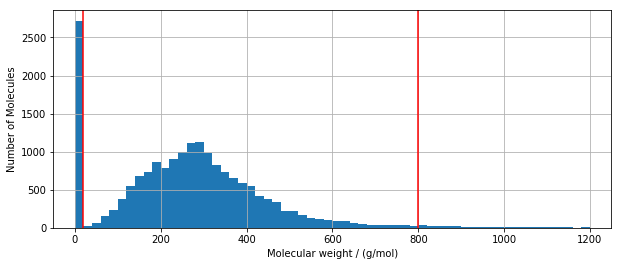

In [47]:
bins = np.linspace(0, 1200, 61)

plt.figure(figsize=(10, 4))
plt.tight_layout()
plt.hist([
    Descriptors.ExactMolWt(m)
    for m in mols_chembl + mols_tox_v1
], bins);
plt.axvline(x=20, color='red')
plt.axvline(x=800, color='red')
plt.xlabel('Molecular weight / (g/mol)')
plt.ylabel('Number of Molecules')
plt.xlim(-50, 1250)
plt.grid()

plt.savefig('../frontend/public/molecular_weight_distribution.svg')

In [22]:
def describe_molecule(m, source):
    props = m.GetPropsAsDict()
    
    mw = Descriptors.ExactMolWt(m)

    print(props)
    if source == 'chembl':
        name = m.GetProp('CHEMBL_ID')
        synonyms = m.GetProp('SYNONYMS')
        active = len(props['WITHDRAWN_REASON']) > 0
        
        drug_type = props['DRUG_TYPE'].lower()
        
        filter_out = 'antibody' in drug_type or 'polypeptide' in drug_type
        
    elif source == 'tox_v1':
        name = m.GetProp('_Name')
        synonyms = ""
        row = df_tox_v1.loc[name]
        active = row.Activity == True
        filter_out = False
        
    if mw < 20 or mw > 800:
        filter_out = True
        
    if name in bad_molecules:
        filter_out = True
        
    return name, synonyms, active, filter_out


LUT = {'chembl': mols_chembl, 'tox_v1': mols_tox_v1}

@widgets.interact(source=sorted(list(LUT.keys())))
def pick(source=mols_chembl):
    mols = LUT[source]

    @widgets.interact(i=(0, len(mols) - 1))
    def show(i=0):
        m = mols[i]
        name, synonyms, active, filter_out = describe_molecule(m, source)
        
        print(name)
        print(synonyms)
        print(active)
        print(filter_out)
        
        display(m)

interactive(children=(Dropdown(description='source', options=('chembl', 'tox_v1'), value='chembl'), Output()),…

In [272]:
df = []
for source, mols in tqdm(LUT.items()):
    for m in tqdm(mols):
        name, synonyms, active, filter_out = describe_molecule(m, source)
        if filter_out:
            continue
        
        df.append({
            'name': name,
            'synonyms': synonyms,
            'source': source,
            'active': active,
            'molecule': m
        })
        
df = pd.DataFrame.from_records(df)

In [273]:
df_filtered = df[
    (df.active & (df.source == 'tox_v1')) | 
    (~df.active & (df.source == 'chembl'))
]

df_filtered.active.value_counts()

False    8496
True     3753
Name: active, dtype: int64

In [274]:
def cluster_mols(fps, cutoff=0.2):
    from rdkit import DataStructs
    from rdkit.ML.Cluster import Butina

    # first generate the distance matrix:
    dists = []
    nfps = len(fps)
    for i in tqdm(range(1,nfps), total=nfps - 1):
        sims = DataStructs.BulkTanimotoSimilarity(fps[i],fps[:i])
        dists.extend([1-x for x in sims])

    # now cluster the data:
    cs = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    return cs

fps = [
    AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) 
    for m in tqdm(df_filtered.molecule)
]

clusters = cluster_mols(fps)

df_centroid = df_filtered.iloc[[c[0] for c in clusters]]

In [275]:
len(df_centroid)

10973

In [276]:
df_centroid.active.value_counts()

False    7730
True     3243
Name: active, dtype: int64

In [277]:
n_smaller_class = min(df_centroid.active.value_counts())
dfs = df_centroid.groupby('active').apply(lambda dfg: dfg.sample(n_smaller_class, random_state=42)).reset_index(drop=True)

In [278]:
dfs.active.value_counts()

True     3243
False    3243
Name: active, dtype: int64

In [279]:
key = []
for _, r in dfs.iterrows():
    digest = hashlib.sha1()
    digest.update(str(r['name']).encode('utf-8'))
    digest.update(r.source.encode('utf-8'))
    key.append(digest.hexdigest())
    
dfs['key'] = key

In [204]:
names_without_synonyms = dfs[pd.isnull(dfs.synonyms)].name
cas_to_sid = {}
sid_to_synonyms = {}

In [209]:
for cas in tqdm(names_without_synonyms):
    if cas in cas_to_sid:
        continue
        
    cas_to_sid[cas] = get_sid_from_cas(cas)
    
sids = {s for ss in cas_to_sid.values() for s in ss}

In [211]:
def grouper(n, iterable):
    it = iter(iterable)
    while True:
       chunk = tuple(itertools.islice(it, n))
       if not chunk:
           return
       yield chunk

In [280]:
print(len(sids))
len(sid_to_synonyms)

36856


36844

In [251]:
todo = [
    sid
    for sid in sids
    if int(sid) not in sid_to_synonyms
]

CHUNK_SIZE=50
for ids in tqdm(grouper(CHUNK_SIZE, todo), total=math.ceil(len(todo) / CHUNK_SIZE)):
    try:
        sts = get_synonyms_from_sid(ids)
    except Exception as e:
        pass
        #print(ids, e)
    
    for k, v in sts.items():
        sid_to_synonyms[k] = v

In [292]:
def get_synonyms_for_cas(cas):
    sids = cas_to_sid[cas]
    out = set()
    for sid in sids:
        sid = int(sid)
        if sid in sid_to_synonyms:
            out |= sid_to_synonyms[sid]
    return out

dfs['synonyms'] = [
    syn if src == 'chembl' else  '; '.join(get_synonyms_for_cas(cas))
    for syn, cas, src in zip(dfs.synonyms, dfs.name, dfs.source)
]

In [293]:
dfs[dfs.source=='tox_v1'][['name', 'synonyms']].head()

name                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    synonyms
3243   88847-41-0  AR-1D8247; ANTI-9-HYDROXYCHRYSENE-1,2-DIOL-3,4-EPOXIDE; 88847-41-0; syn-Chrysenetriol epoxide; 2-amino-3-chloro-9h-fluoren-9-ol; C18-H14-O4; (Z)-1,2,2a,3a-Tetrahydrochryseno(3,4-b)oxirene-1,2,8-triol; CCRIS 2035; syn-9-Hydroxychrysenediol 3,4-oxide; anti-9-Hydroxychrysene-1,2-diol-3,4-epoxide; CTK5G1947; Chryseno(3,4-b)oxirene-1,2,8-triol, 1,2,2a,3a-tetrahydro-, (1-alpha,2-beta,2a-alpha,3a-alpha)-; (7s,8r,8ar,9as)-7,8,8a,9a-tetrahydrochryseno[3,4-b]oxirene-3,7,8-triol; 9-Hydroxy-r-1,t-2-dihydroxy-c-3,4-oxy-1,2,3,4-tetrahydrochrysene
3244  131862-18-5                                                                                                                                                                                                                                                  N-[2-(DIMETHYLAMINO)ETHYL]-1,10-PHENANTHROLINE-2-CARBOXAMIDE; CCRIS 4469; N-(2-(Dimethylamino)ethyl)-1,10-phenanthroline-2-carboxamide; CTK4B7573; n-(2-(dimethylamino)ethyl)-1,10-phenanthroline-2-carboxamide; N-(2-(DIMETHYLAMINO)ETHYL)-1,10-PHENANTHROLINE-2-CARBOXAMIDE; DTXSID30157233; 131862-18-5
3245    5831-16-3                                                                                               16,17-DIHYDRO-11,17-DIMETHYL-15H-CYCLOPENTA(A)PHENANTHRENE; 15H-Cyclopenta[a]phenanthrene, 16,17-dihydro-11,17-dimethyl-; C19-H17; 16,17-Dihydro-11,17-dimethylcyclopenta(a)phenanthrene; 16,17-Dihydro-11,17-dimethyl-15H-cyclopenta[a]phenanthrene; 15H-Cyclopenta(a)phenanthrene, 11,17-dimethyl-16,17-dihydro-; 5831-16-3; 16,17-Dihydro-11,17-dimethyl-15H-cyclopenta(a)phenanthrene; 11,17-Dimethyl-16,17-dihydro-15H-cyclopenta(a)phenanthrene; C19H17
3246  105500-28-5                                             Benz(a)oxireno(3,4)benz(1,2-j)acridine-2,3-diol, 1a,2,3,13c-tetrahydro-, (1a-alpha,2-beta,3-alpha,13c-alpha)-; 1a-alpha,2-beta,3-alpha,13c-alpha-Tetrahydrobenz(a)oxireno(3,4)benz(1,2-j)acridine-2,3-diol; C21-H15-N-O2; CCRIS 3318; (1aalpha,2beta,3alpha,13calpha)-1a,2,3,13c-Tetrahydrobenz(a)oxireno(3,4)benz(1,2-j)acridine-2,3-diol; (1AALPHA, 2BETA, 3ALPHA, 13CALPHA)-1A,2,3,13C-TETRAHYDROBENZ[A]OXIRENO[3,4]BENZ[1,2-J]ACRIDINE-2,3-DIOL; anti-Dibenz(a,j)acridine-3,4-diol-1,2-epoxide; 105500-28-5
3247  153654-34-3                                                                                                                                                                                                                                                                                                                                                                 CCRIS 6775; 9H-Carbazol-2-ol,1,3-dinitro-; ACMC-1C2KK; CTK4C7938; 153654-34-3; 2-HYDROXY-1,3-DINITROCARBAZOLE; DTXSID10165391; 1,3-Dinitro-9H-carbazol-2-ol; 2-Hydroxy-1,3-dinitrocarbazole

In [294]:
for _, r in tqdm(dfs.iterrows(), total=len(dfs)):
    key = r['key']
    mol = r['molecule']
    
    try:
        Chem.Draw.MolToFile(mol, '../backend/images/{}.svg'.format(key), size=(600, 600))
                
    except UnicodeEncodeError:
        print(r['name'])

In [296]:
dfs.to_pickle('../data/mols_raw.pkl')

# Enrichment

In [80]:
dfs = pd.read_pickle('../data/mols_raw.pkl')

In [86]:
moldict_chembl = {
    m.GetProp('CHEMBL_ID'): m
    for m in mols_chembl
}

indications = []
usans = []
atcs = []

RE_ATC = re.compile(r'\[(.*)\]')

for _, r in dfs.iterrows():
    if r.active: 
        indications.append('')
        usans.append('')
        atcs.append('')
        
    else:
        mol = moldict_chembl[r['name']]
        props = mol.GetPropsAsDict()
        
        indication = props.get('INDICATION_CLASS')
        usan = props.get('USAN_STEM_DEFINITION')
        
        atc = None
        m = RE_ATC.search(props.get('ATC_CODE_DESCRIPTION', ''))
        if m:
            atc = m.group(1).lower()
        
        indications.append(indication)
        usans.append(usan)
        atcs.append(atc)
        
    
dfs['indication'] = indications
dfs['usan'] = usans
dfs['atc'] = atcs

In [82]:
dfs.iloc[19]   # 19

active                                                    False
molecule       <rdkit.Chem.rdchem.Mol object at 0x7f504b4ce5a8>
name                                              CHEMBL1851805
source                                                   chembl
synonyms                           Propacetamol (BAN, INN, MI);
key                    26d1ba6ebf25fac749c61c21c708c253e3129e23
indication                                                     
usan                                                           
atc           blood and blood forming organs: antihemorrhagi...
Name: 19, dtype: object

In [87]:
for _, r in tqdm(dfs.iterrows(), total=len(dfs)):
    key = r['key']
    mol = r['molecule']
    
    try:
        with open('../backend/labels/{}.json'.format(key), 'w') as f:
            json.dump(r.drop('molecule').to_dict(), f, indent=2)
        
    except UnicodeEncodeError:
        print(r['name'])

In [83]:
dfs.to_pickle('../data/mols.pkl')